In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#parameters
in_file = '../../merge/reformatted_data_with_features.txt'
out_dir = 'ATAC_short_results'
metadata_file = '../../../../../metadata/MBC/merged_key_metadata.txt'
status_col = 'merged_updated_ER_status_binary'
n_iter = 1000

In [3]:
#import data
data = pd.read_csv(in_file, sep='\t')
data = data.set_index('sample')

#get features and exclude all other columns
features = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('fft_10_magnitude'))]
data = data[features]
print('features',len(features))

#get metadata
metadata = pd.read_csv(metadata_file, sep='\t')
metadata = metadata.set_index('sample')
data = data.merge(metadata, left_index=True, right_index=True)
data['status'] = np.where(data[status_col]=='+',1,0)

#filter data
min_tfx = 0.05
min_cov = 0.1

#training data
data = data[(data['tumor_fraction']>=min_tfx) & (data['ulp_wgs_coverage']>=min_cov)]
print('total',len(data))
print(data[status_col].value_counts())

high_tfx = data[(data['tumor_fraction']>=0.1) & (data['ulp_wgs_coverage']>=min_cov)]
print('high tfx',len(high_tfx))
print(high_tfx[status_col].value_counts())
del(high_tfx)

data = data.sort_index()

features 12
total 254
+    132
-    122
Name: merged_updated_ER_status_binary, dtype: int64
high tfx 191
+    99
-    92
Name: merged_updated_ER_status_binary, dtype: int64


In [4]:
features

Index(['central_cov_ER_neg_0_5_FC', 'central_cov_ER_neg_heme_0_5_FC',
       'central_cov_ER_pos_0_5_FC', 'central_cov_ER_pos_heme_0_5_FC',
       'fft_10_magnitude_ER_neg_0_5_FC', 'fft_10_magnitude_ER_neg_heme_0_5_FC',
       'fft_10_magnitude_ER_pos_0_5_FC', 'fft_10_magnitude_ER_pos_heme_0_5_FC',
       'mean_cov_ER_neg_0_5_FC', 'mean_cov_ER_neg_heme_0_5_FC',
       'mean_cov_ER_pos_0_5_FC', 'mean_cov_ER_pos_heme_0_5_FC'],
      dtype='object')

In [5]:
#view data
data.head()

,central_cov_ER_neg_0_5_FC,central_cov_ER_neg_heme_0_5_FC,central_cov_ER_pos_0_5_FC,central_cov_ER_pos_heme_0_5_FC,fft_10_magnitude_ER_neg_0_5_FC,fft_10_magnitude_ER_neg_heme_0_5_FC,fft_10_magnitude_ER_pos_0_5_FC,fft_10_magnitude_ER_pos_heme_0_5_FC,mean_cov_ER_neg_0_5_FC,mean_cov_ER_neg_heme_0_5_FC,...,merged_ER_switch,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample,status
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1041_1_ULP,0.965477,0.940257,0.892628,0.835157,0.595958,2.229215,0.774053,1.241152,0.983638,0.990200,...,same,+,+,-,+,gain,6746.0,1.0,1.0,1
MBC_1041_3_ULP,0.932625,1.097697,0.918312,0.958195,0.433888,2.333185,1.336454,1.241714,0.990873,0.984667,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1041_4_ULP,0.961175,0.980140,0.948762,0.922330,0.159651,1.274082,0.676746,2.120007,0.989275,0.983294,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1042_1_ULP,0.941998,0.940880,0.989420,0.918950,0.874080,2.086663,1.979152,2.829281,0.979832,1.013303,...,same,+,+,+,-,loss,2116.0,1.0,NaN,1
MBC_1042_2_ULP,0.987565,0.938635,0.888875,0.941710,1.198680,1.003786,1.197261,1.107512,0.994663,0.966407,...,same,+,+,+,-,loss,2116.0,1.0,1.0,1


In [6]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

central_cov_ER_neg_0_5_FC             -1.188900e-15
central_cov_ER_neg_heme_0_5_FC        -7.273272e-16
central_cov_ER_pos_0_5_FC             -2.237930e-16
central_cov_ER_pos_heme_0_5_FC         1.307790e-15
fft_10_magnitude_ER_neg_0_5_FC        -1.398706e-16
fft_10_magnitude_ER_neg_heme_0_5_FC    6.294178e-17
fft_10_magnitude_ER_pos_0_5_FC        -7.692884e-17
fft_10_magnitude_ER_pos_heme_0_5_FC    1.818318e-16
mean_cov_ER_neg_0_5_FC                 3.916377e-16
mean_cov_ER_neg_heme_0_5_FC            1.377726e-15
mean_cov_ER_pos_0_5_FC                -6.112346e-15
mean_cov_ER_pos_heme_0_5_FC           -5.524889e-16
dtype: float64

In [7]:
#bootstrapping
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

#loop for each iteration
countup = 0
for i in range(n_iter):
    if i%50==0:
        print(i,countup, time.time()-start_time)
    
    patients = pd.Series(data['patient_id'].unique())
    
    good_split = 0
    while good_split == 0:
        #bootstrap a training set with replacement
        training_ids = patients.sample(len(patients), replace = True, random_state = 100+countup)
                
        #get bootstrapped training set, if a patient ID is included in the training_ids set j times, include all samples from that patient j times
        training = pd.DataFrame()
        
        #group the training patient IDs by number of times they are observed in the bootstrapped training_ids
        for j,df in pd.DataFrame(training_ids.value_counts().rename('count')).groupby(by = 'count'):

            #identify the samples from this group of patients
            current_data = data[data['patient_id'].isin(df.index)]

            #copy the training samples so that they appear j times in training dataframe
            current_training = pd.DataFrame()
            for k in range(j):
                current_training = current_training.append(current_data)
            training = training.append(current_training)
        
        
        #the test set is all samples that aren't seen in the training data
        test = data[~(data.index.isin(training.index))]
        
        #check to make sure first time point low tumor fraction samples for both classes are included in the test set
        if len(test[(test['tumor_fraction']<.1) & (test['first_passing_sample']==1)]['status'].unique())!=2:
            print('skipping iteration',i)
            countup += 1
        else:
            good_split = 1
    
    #countup will get ahead of i if it has to skip bad train-test splits
    countup +=1
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state =100+countup) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 1)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    current_output['prediction']=pred
    current_output['accuracy'] = np.where(current_output['prediction']==current_output['status'],1,0)    
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)
    

probabilities = probabilities.merge(data[['status']], left_index=True, right_index=True)

0 0 0.0011031627655029297
50 50 10.436439037322998
100 100 19.600762128829956
150 150 29.34201431274414
200 200 39.71533203125
250 250 49.820003032684326
300 300 58.60719919204712
350 350 67.8687310218811
400 400 77.11448693275452
450 450 85.910001039505
500 500 94.91938090324402
550 550 103.44913721084595
600 600 111.99848222732544
650 650 120.46170711517334
700 700 128.87884521484375
skipping iteration 715
750 751 137.68737602233887
800 801 145.9633162021637
850 851 154.44428205490112
900 901 163.01565718650818
950 951 171.5232071876526


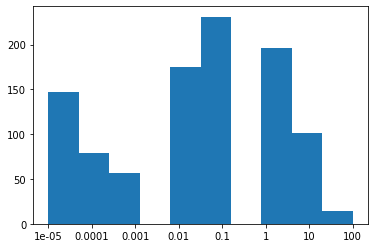

In [8]:
#export results
probabilities.to_csv(out_dir+'/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(out_dir+'/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(out_dir+'/coefs.txt', sep='\t')

plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(out_dir+'/cvals.pdf')

In [9]:
#print some key info

In [10]:
probabilities = probabilities.merge(data[['first_passing_sample','tumor_fraction']], left_index=True, right_index=True)

In [11]:
#high tfx per patient accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']>=0.1) & (current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.7322841911985689

In [12]:
#per sample accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']>=0.1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
np.mean(accuracy)

0.714899262575987

In [13]:
#low tfx per patient accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']<0.1) & (current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.4556951141330364

In [14]:
#per sample accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']<0.1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
np.mean(accuracy)

0.5143140758250851

In [15]:
#per patient accuracy for all samples
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'first_passing_sample','status']]
    current = current[(current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.6563718488205279

In [16]:
#per sample accuracy for all samples
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status']]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.6651309566267114